In [1]:
!pip install wandb

In [2]:
import wandb
wandb.login()
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: viinod9 (viinod9-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

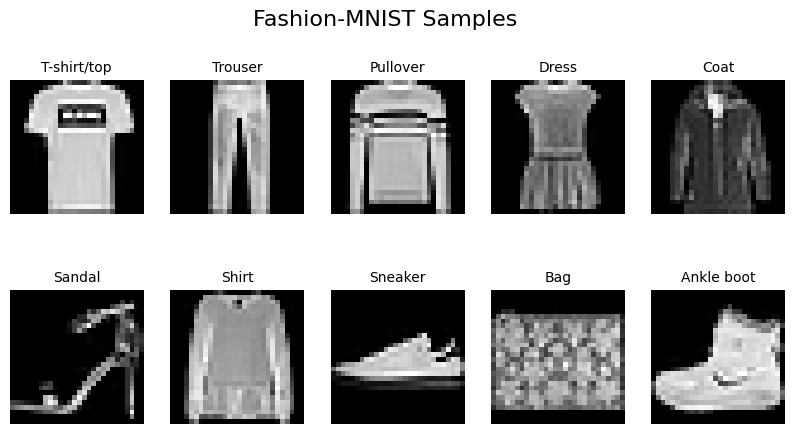

Training images shape: (48000, 784)
Training labels shape: (48000, 10)
Validation images shape: (12000, 784)
Validation labels shape: (12000, 10)
Testing images shape: (10000, 784)
Testing labels shape: (10000, 10)


wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Initialize WandB
wandb.login()  # Ensure you are logged in
wandb.init(project='Fashion-MNIST-Visualization', entity='viinod9-iitm')

# Load the Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Define class labels
class_labels = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

# Select one sample per class
sample_images = []
sample_labels = []

for label in range(10):
    idx = next(i for i, j in enumerate(y_train) if j == label)  # Find first occurrence
    sample_images.append(X_train[idx])
    sample_labels.append(class_labels[label])

# Plot and log images to WandB
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap="gray")
    ax.set_title(sample_labels[i], fontsize=10)
    ax.axis("off")

plt.show()

# Log images to WandB
wandb.log({"Fashion-MNIST Samples": [wandb.Image(img, caption=label) for img, label in zip(sample_images, sample_labels)]})

# Split data for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Flatten images
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize images
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

# One-hot encoding function
def one_hot_encod(arr):
    mat = np.zeros((len(arr), 10))
    for i in range(len(arr)):
        mat[i, arr[i]] = 1
    return mat

# Convert labels to one-hot encoding
Y_train, Y_valid, Y_test = one_hot_encod(y_train), one_hot_encod(y_valid), one_hot_encod(y_test)

# Print dataset shapes
print("Training images shape:", X_train.shape)
print("Training labels shape:", Y_train.shape)
print("Validation images shape:", X_valid.shape)
print("Validation labels shape:", Y_valid.shape)
print("Testing images shape:", X_test.shape)
print("Testing labels shape:", Y_test.shape)

# Finish WandB run
wandb.finish()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
def init_network( num_hidden_layer, num_nodes_hidden_layers, weight, input_size, output_size ):
    network_size = []
    for i in range(num_hidden_layer):
      network_size.append(num_nodes_hidden_layers)
    size = [input_size] + network_size + [output_size]
    theta0 = {}
    if weight == 'random':
      for i in range(1, num_hidden_layer+2):
        theta0['W' + str(i)] = np.random.randn(size[i], size[i-1])
        theta0['b' + str(i)] = np.random.randn(size[i], 1)
    if weight == 'xavier':
      for i in range(1, num_hidden_layer+2):
          theta0["W" + str(i)] = np.random.randn(size[i], size[i-1])*(np.sqrt(2/(size[i-1])))
          theta0["b" + str(i)] = np.random.randn(size[i], 1)*(np.sqrt(2/(size[i-1])))

    return theta0

def sigmoid(x):
  return 1 /(1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
	return np.tanh(x)

def deriv_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

def deriv_relu(x):
  return np.where(x <= 0, 0, 1)

def deriv_tanh(x):
  return (1 - (tanh(x))**2)

def softmax(x):
  x = x - np.max(x)
  return np.exp(x)/np.sum(np.exp(x),axis=0)

def activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return sigmoid(x)
  elif activ_fun == 'relu':
    return relu(x)
  else:
    return tanh(x)

def grad_activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return deriv_sigmoid(x)
  elif activ_fun == 'relu':
    return deriv_relu(x)
  else:
    return deriv_tanh(x)

def cross_entropy(y_actual, y_pred):
    epsilon = 1e-15  # to prevent log(0) which is undefined
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(np.sum(y_actual * np.log(y_pred), axis=0))
    return loss


def forword_prop(x,theta,activ_fun, num_hidden_layer,input_size):
  a = {}
  a['a'+str(0)] = np.zeros((input_size,1))
  h = {'h0':x}
  for i in range(1,num_hidden_layer+1):
    a["a"+str(i)] = np.dot(theta['W'+str(i)],h['h'+str(i-1)]) + theta['b'+str(i)]
    h['h'+str(i)] = activation(a["a"+str(i)], activ_fun)
  a['a'+str(num_hidden_layer+1)] = np.dot(theta['W'+str(num_hidden_layer+1)],h['h'+str(num_hidden_layer)]) + theta['b'+str(num_hidden_layer+1)]
  y_pred = softmax(a['a'+str(num_hidden_layer+1)])

  return a,h,y_pred

In [2]:
def back_prop(x, y_actual, activ_fun, num_hidden_layer, theta,input_size):
  a,h,y_pred = forword_prop(x,theta,activ_fun, num_hidden_layer,input_size)
  grad_W_b = {}
  grad_h_a = {}
  grad_h_a['a'+str(num_hidden_layer+1)] = -1*(y_actual - y_pred)
  for i in range(num_hidden_layer+1, 0, -1):
    grad_W_b['W'+str(i)] = np.dot(grad_h_a['a'+str(i)],h['h'+str(i-1)].T)
    grad_W_b['b'+str(i)] = grad_h_a['a'+str(i)]  #np.mean(grad_h_a['a'+str(i)]#,axis = 0, keepdims=True)
    grad_h_a['h'+str(i-1)] = np.dot(theta['W'+str(i)].T,grad_h_a['a'+str(i)] )
    grad_h_a['a'+str(i-1)] = grad_h_a['h'+str(i-1)]*(grad_activation(a['a'+str(i-1)], activ_fun))

  return grad_W_b


def calculate_accuracy(X_test,y_test,theta_new,activ_fun, num_hidden_layer,input_size):
  len = X_test.shape[0]
  correct_predictions = 0
  for i in range(len):
    X_tes = X_test[i,:].reshape(-1, 1)
    a,h,y_test_pred = forword_prop(X_tes,theta_new, activ_fun, num_hidden_layer,input_size)

    y1 = np.argmax(y_test[i,:].reshape(-1, 1), axis = 0)
    y2 = np.argmax(y_test_pred, axis = 0)

    if y1 == y2:
      correct_predictions += 1
  accuracy = correct_predictions /y_test.shape[0]

  return accuracy

"""Optimizers"""

# Stochastic Gradient Decent
def sgd(lr, x_train, y_train, X_valid, Y_valid, epochs, activ_fun, num_hidden_layer,num_nodes_hidden_layers, weight,batch_size, input_size, output_size):
  theta = init_network( num_hidden_layer, num_nodes_hidden_layers, weight, input_size, output_size )
  losses = []  # List to store the loss for each epoch
  length = x_train.shape[0]

  for epoch in range(epochs):
      arr = np.arange(length)
      np.random.shuffle(arr)
      no_of_pts = 0
      grad_new = {key: np.zeros_like(value) for key, value in theta.items()}
      for j in range(length):
          no_of_pts += 1
          x = x_train[arr[j],:].reshape(-1, 1)
          y_actual = y_train[arr[j],:].reshape(-1, 1)
          grad = back_prop(x, y_actual, activ_fun, num_hidden_layer, theta,input_size)
          for k in range(1, num_hidden_layer + 2):
            grad_new['W' + str(k)] += grad['W' + str(k)]
            grad_new['b' + str(k)] += grad['b' + str(k)]
          if no_of_pts % batch_size == 0:
            for i in range(1, num_hidden_layer + 2):
                theta['W' + str(i)] -= lr * grad_new['W' + str(i)]
                theta['b' + str(i)] -= lr * grad_new['b' + str(i)]

      # Compute and store the loss and accuracy for this epoch
      acc = calculate_accuracy(x_train,y_train,theta,activ_fun, num_hidden_layer,input_size)
      a, _, y_pred = forword_prop(x_train.T,theta,activ_fun, num_hidden_layer,input_size)
      loss = cross_entropy(y_train.T, y_pred)
      losses.append(loss)
      validation_accuracy = calculate_accuracy(X_valid,Y_valid,theta,activ_fun, num_hidden_layer,input_size)


      print(f"Epoch {epoch+1}, train Loss: {loss} , train accuracy: {acc*100}, validation accuracy: {validation_accuracy*100}")


  # Plot the loss function over epochs
  plt.plot(losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')
  plt.show()

  return theta

# Momentum based gradient decent

def momentum(lr, theta, x_train, y_train, X_valid, Y_valid, activ_fun, epochs, num_hidden_layer, input_size, batch_size, beta=0.9):
    losses = []  # List to store the loss for each epoch
    length = x_train.shape[0]
    v = {key: np.zeros_like(value) for key, value in theta.items()}  # Initialize velocities
    prev_v = {key: np.zeros_like(value) for key, value in theta.items()}
    for epoch in range(epochs):  # Adjust the number of epochs as needed
        no_of_pts = 0
        loss = 0
        itr = 0
        no_of_batch = 0
        grad_new = {key: np.zeros_like(value) for key, value in theta.items()}
        for j in range(length):
            no_of_pts += 1
            x = x_train[j, :].reshape(-1, 1)
            y_actual = y_train[j, :].reshape(-1, 1)
            grad = back_prop(x, y_actual,activ_fun, num_hidden_layer, theta, input_size)
            for i in range(num_hidden_layer+1, 0, -1):
                grad_new['W'+str(i)] += grad['W'+str(i)]
                grad_new['b'+str(i)] += grad['b'+str(i)]

            if no_of_pts % batch_size == 0:
              no_of_batch += 1
              for i in range(1, num_hidden_layer + 2):
                  # Update velocity
                  v['W' + str(i)] = beta * prev_v['W' + str(i)] + lr * grad_new['W'+str(i)]
                  v['b' + str(i)] = beta * prev_v['b' + str(i)] + lr * grad_new['b'+str(i)]

              for i in range(1, num_hidden_layer + 2):
                  # Update parameters
                  theta['W' + str(i)] -= v['W' + str(i)]
                  theta['b' + str(i)] -= v['b' + str(i)]

              for i in range(1, num_hidden_layer + 2):
                  prev_v['W' + str(i)] = v['W' + str(i)]
                  prev_v['b' + str(i)] = v['b' + str(i)]

        # Compute and store the loss for this epoch
                  # x_batch = X_train[itr:itr+batch_size].T
                  # y_batch = Y_train[itr:itr+batch_size].T
                  # itr += batch_size
                  # a, _, y_pred = forword_prop(x_batch, theta,activ_fun, num_hidden_layer, input_size)
                  # loss += cross_entropy(y_batch, y_pred)#-np.mean(np.sum(y_batch.T * np.log(y_pred),axis = 0))
        acc = calculate_accuracy(x_train,y_train,theta,activ_fun, num_hidden_layer,input_size)
        a, _, y_pred = forword_prop(x_train.T,theta,activ_fun, num_hidden_layer,input_size)
        loss = cross_entropy(y_train.T, y_pred)
        losses.append(loss)
        validation_accuracy = calculate_accuracy(X_valid,Y_valid,theta,activ_fun, num_hidden_layer,input_size)


        print(f"Epoch {epoch+1}, train Loss: {loss} , train accuracy: {acc*100}, validation accuracy: {validation_accuracy*100}")

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return theta

# Nestrov acelarated gradient decent
def nag(lr, theta, x_train, y_train, X_valid, Y_valid, activ_fun, epochs, num_hidden_layer, input_size, batch_size, beta=0.9):
    losses = []
    length = x_train.shape[0]
    v = {key: np.zeros_like(value) for key, value in theta.items()}
    prev_v = {key: np.zeros_like(value) for key, value in theta.items()}
    for epoch in range(epochs):
        grad_new = {key: np.zeros_like(value) for key, value in theta.items()}
        no_of_pts = 0
        no_of_batch = 0
        loss = 0
        itr = 0
        for j in range(length):
            no_of_pts += 1
            x = x_train[j, :].reshape(-1, 1)
            y_actual = y_train[j, :].reshape(-1, 1)

            for i in range(1, num_hidden_layer + 2):
              theta['W' + str(i)] -= beta * prev_v['W' + str(i)]
              theta['b' + str(i)] -= beta * prev_v['b' + str(i)]

            grad = back_prop(x, y_actual,activ_fun, num_hidden_layer, theta, input_size)
            for i in range(num_hidden_layer+1, 0, -1):
                grad_new['W'+str(i)] += grad['W'+str(i)]
                grad_new['b'+str(i)] += grad['b'+str(i)]

            if no_of_pts % batch_size == 0:
              no_of_batch += 1
              for i in range(1, num_hidden_layer + 2):
                  # Update velocity
                  v['W' + str(i)] = beta * prev_v['W' + str(i)] + lr * grad_new['W'+str(i)]
                  v['b' + str(i)] = beta * prev_v['b' + str(i)] + lr * grad_new['b'+str(i)]

              for i in range(1, num_hidden_layer + 2):
                  # Update parameters
                  theta['W' + str(i)] -= v['W' + str(i)]
                  theta['b' + str(i)] -= v['b' + str(i)]

              for i in range(1, num_hidden_layer + 2):
                  prev_v['W' + str(i)] = v['W' + str(i)]
                  prev_v['b' + str(i)] = v['b' + str(i)]

                  # x_batch = X_train[itr:itr+batch_size].T
                  # y_batch = Y_train[itr:itr+batch_size]
                  # itr += batch_size
                  # a, _, y_pred = forword_prop(x_batch, theta,activ_fun, num_hidden_layer, input_size)
                  # epsilon = 1e-15  # to prevent log(0) which is undefined
                  # y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
                  # loss += -np.mean(np.sum(y_batch.T * np.log(y_pred),axis = 0))
        acc = calculate_accuracy(x_train,y_train,theta,activ_fun, num_hidden_layer,input_size)
        a, _, y_pred = forword_prop(x_train.T,theta,activ_fun, num_hidden_layer,input_size)
        loss = cross_entropy(y_train.T, y_pred)
        losses.append(loss)
        validation_accuracy = calculate_accuracy(X_valid,Y_valid,theta,activ_fun, num_hidden_layer,input_size)


        print(f"Epoch {epoch+1}, train Loss: {loss} , train accuracy: {acc*100}, validation accuracy: {validation_accuracy*100}")


    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return theta

# RMSprop optimizer

def opt_RMSprop(lr, theta, x_train, y_train,X_valid, Y_valid,activ_fun, epochs, num_hidden_layer, input_size,batch_size, eps=0.01, beta=0.9):
    losses = []
    length = x_train.shape[0]
    v = {key: np.zeros_like(value) for key, value in theta.items()}
    prev_v = {key: np.zeros_like(value) for key, value in theta.items()}
    for epoch in range(epochs):
        no_of_pts = 0
        loss = 0
        grad_new = {key: np.zeros_like(value) for key, value in theta.items()}
        for j in range(length):
            no_of_pts += 1
            x = x_train[j, :].reshape(-1, 1)
            y_actual = y_train[j, :].reshape(-1, 1)
            grad = back_prop(x, y_actual,activ_fun, num_hidden_layer, theta, input_size)
            for i in range(num_hidden_layer+1, 0, -1):
                grad_new['W'+str(i)] += grad['W'+str(i)]
                grad_new['b'+str(i)] += grad['b'+str(i)]

            if no_of_pts % batch_size == 0:

              for i in range(1, num_hidden_layer + 2):
                  # Update velocity
                  v['W' + str(i)] = beta * prev_v['W' + str(i)] + (1-beta)* ((grad_new['W'+str(i)])**2)
                  v['b' + str(i)] = beta * prev_v['b' + str(i)] + (1-beta)* ((grad_new['b'+str(i)])**2)

              for i in range(1, num_hidden_layer + 2):
                  # Update parameters
                  theta['W' + str(i)] -= (lr/ (np.sqrt(v['W' + str(i)] + eps)) )*grad_new['W'+str(i)]
                  theta['b' + str(i)] -= (lr/ (np.sqrt(v['b' + str(i)] + eps)) )*grad_new['b'+str(i)]

              for i in range(1, num_hidden_layer + 2):
                  prev_v['W' + str(i)] = v['W' + str(i)]
                  prev_v['b' + str(i)] = v['b' + str(i)]


        acc = calculate_accuracy(x_train,y_train,theta,activ_fun, num_hidden_layer,input_size)
        a, _, y_pred = forword_prop(x_train.T,theta,activ_fun, num_hidden_layer,input_size)
        loss = cross_entropy(y_train.T, y_pred)
        losses.append(loss)
        validation_accuracy = calculate_accuracy(X_valid,Y_valid,theta,activ_fun, num_hidden_layer,input_size)
        print(f"Epoch {epoch+1}, Train_Loss: {loss} , Train_Accuracy: {acc*100},Test accutacy: {validation_accuracy*100}")

    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return theta

# Optimizer Adam
def opt_Adam(lr, theta, x_train, y_train, X_valid, Y_valid, activ_fun, epochs, num_hidden_layer, input_size,batch_size,eps, beta1=0.9,beta2= 0.99):
    losses = []
    length = x_train.shape[0]
    v = {key: np.zeros_like(value) for key, value in theta.items()}
    prev_v = {key: np.zeros_like(value) for key, value in theta.items()}
    v_cap = {key: np.zeros_like(value) for key, value in theta.items()}

    m = {key: np.zeros_like(value) for key, value in theta.items()}
    prev_m = {key: np.zeros_like(value) for key, value in theta.items()}
    m_cap = {key: np.zeros_like(value) for key, value in theta.items()}

    for epoch in range(epochs):
        t = 0
        no_of_pts = 0
        loss = 0
        grad_new = {key: np.zeros_like(value) for key, value in theta.items()}
        for j in range(length):
            x = x_train[j, :].reshape(-1, 1)
            y_actual = y_train[j, :].reshape(-1, 1)
            grad = back_prop(x, y_actual,activ_fun, num_hidden_layer, theta, input_size)
            for i in range(num_hidden_layer+1, 0, -1):
                grad_new['W'+str(i)] += grad['W'+str(i)]
                grad_new['b'+str(i)] += grad['b'+str(i)]

            no_of_pts = no_of_pts + 1
            if no_of_pts % batch_size == 0:
              t = t + 1

              for i in range(1, num_hidden_layer + 2):
                  m['W' + str(i)] = beta1 * prev_m['W' + str(i)] + (1-beta1)* grad_new['W'+str(i)]
                  m['b' + str(i)] = beta1 * prev_m['b' + str(i)] + (1-beta1)* grad_new['b'+str(i)]

              for i in range(1, num_hidden_layer + 2):
                  m_cap['W' + str(i)] = (1/(1-np.power(beta1,t))) * m['W' + str(i)]
                  m_cap['b' + str(i)] = (1/(1-np.power(beta1,t))) * m['b' + str(i)]
                  prev_m['W' + str(i)] = m['W' + str(i)]
                  prev_m['b' + str(i)] = m['b' + str(i)]

              for i in range(1, num_hidden_layer + 2):
                  v['W' + str(i)] = beta2 * prev_v['W' + str(i)] + (1-beta2)* ((grad_new['W'+str(i)])**2)
                  v['b' + str(i)] = beta2 * prev_v['b' + str(i)] + (1-beta2)* ((grad_new['b'+str(i)])**2)

              for i in range(1, num_hidden_layer + 2):
                  v_cap['W' + str(i)] = (1/(1-np.power(beta2,t))) * v['W' + str(i)]
                  v_cap['b' + str(i)] = (1/(1-np.power(beta2,t))) * v['b' + str(i)]
                  prev_v['W' + str(i)] = v['W' + str(i)]
                  prev_v['b' + str(i)] = v['b' + str(i)]


              for i in range(1, num_hidden_layer + 2):
                  # Update parameters
                  theta['W' + str(i)] -= (lr/ (np.sqrt(v_cap['W' + str(i)] + eps)) )*(m_cap['W'+str(i)])
                  theta['b' + str(i)] -= (lr/ (np.sqrt(v_cap['b' + str(i)] + eps)) )*(m_cap['b'+str(i)])


        acc = calculate_accuracy(x_train,y_train,theta,activ_fun, num_hidden_layer,input_size)
        a, _, y_pred = forword_prop(x_train.T,theta,activ_fun, num_hidden_layer,input_size)
        loss = cross_entropy(y_train.T, y_pred)
        losses.append(loss)
        validation_accuracy = calculate_accuracy(X_valid,Y_valid,theta,activ_fun, num_hidden_layer,input_size)
        print(f"Epoch {epoch+1}, Train_Loss: {loss} , Train_Accuracy: {acc*100},Test accutacy: {validation_accuracy*100}")
    # Plot the loss function over epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return theta

# Optimizer Nadam
def opt_Nadam(lr, theta, x_train, y_train,X_valid, Y_valid,activ_fun, epochs, num_hidden_layer, input_size, batch_size,eps, beta1=0.9,beta2=0.99):
    losses = []
    length = x_train.shape[0]
    v = {key: np.zeros_like(value) for key, value in theta.items()}
    prev_v = {key: np.zeros_like(value) for key, value in theta.items()}
    v_cap = {key: np.zeros_like(value) for key, value in theta.items()}

    m = {key: np.zeros_like(value) for key, value in theta.items()}
    prev_m = {key: np.zeros_like(value) for key, value in theta.items()}
    m_cap = {key: np.zeros_like(value) for key, value in theta.items()}

    for epoch in range(epochs):
        t = 0
        no_of_pts = 0
        loss = 0
        grad_new = {key: np.zeros_like(value) for key, value in theta.items()}
        for j in range(length):
            x = x_train[j, :].reshape(-1, 1)
            y_actual = y_train[j, :].reshape(-1, 1)
            grad = back_prop(x, y_actual,activ_fun, num_hidden_layer, theta, input_size)
            for i in range(num_hidden_layer+1, 0, -1):
                grad_new['W'+str(i)] += grad['W'+str(i)]
                grad_new['b'+str(i)] += grad['b'+str(i)]

            no_of_pts += 1
            if no_of_pts % batch_size == 0:
              t = t + 1

              for i in range(1, num_hidden_layer + 2):
                  m['W' + str(i)] = beta1 * prev_m['W' + str(i)] + (1-beta1)* grad_new['W'+str(i)]
                  m['b' + str(i)] = beta1 * prev_m['b' + str(i)] + (1-beta1)* grad_new['b'+str(i)]

              for i in range(1, num_hidden_layer + 2):
                  m_cap['W' + str(i)] = (1/(1-np.power(beta1,t))) * m['W' + str(i)]
                  m_cap['b' + str(i)] = (1/(1-np.power(beta1,t))) * m['b' + str(i)]
                  prev_m['W' + str(i)] = m['W' + str(i)]
                  prev_m['b' + str(i)] = m['b' + str(i)]

              for i in range(1, num_hidden_layer + 2):
                  v['W' + str(i)] = beta2 * prev_v['W' + str(i)] + (1-beta2)* ((grad_new['W'+str(i)])**2)
                  v['b' + str(i)] = beta2 * prev_v['b' + str(i)] + (1-beta2)* ((grad_new['b'+str(i)])**2)

              for i in range(1, num_hidden_layer + 2):
                  v_cap['W' + str(i)] = (1/(1-np.power(beta2,t))) * v['W' + str(i)]
                  v_cap['b' + str(i)] = (1/(1-np.power(beta2,t))) * v['b' + str(i)]
                  prev_v['W' + str(i)] = v['W' + str(i)]
                  prev_v['b' + str(i)] = v['b' + str(i)]


              for i in range(1, num_hidden_layer + 2):
                  # Update parameters
                  theta['W' + str(i)] -= (lr/ (np.sqrt(v_cap['W' + str(i)] + eps)) )*(beta1*(m_cap['W'+str(i)])+((1-beta1)*(grad_new['W'+str(i)]))/(1-np.power(beta1,t)))
                  theta['b' + str(i)] -= (lr/ (np.sqrt(v_cap['b' + str(i)] + eps)) )*(beta1*(m_cap['b'+str(i)])+((1-beta1)*(grad_new['b'+str(i)]))/(1-np.power(beta1,t)))

        acc = calculate_accuracy(x_train,y_train,theta,activ_fun, num_hidden_layer,input_size)
        a, _, y_pred = forword_prop(x_train.T,theta,activ_fun, num_hidden_layer,input_size)
        loss = cross_entropy(y_train.T, y_pred)
        losses.append(loss)
        test_accuracy = calculate_accuracy(X_valid,Y_valid,theta,activ_fun, num_hidden_layer,input_size)

        print(f"Epoch {epoch+1}, Train_Loss: {loss} , Train_Accuracy: {acc*100},Test accutacy: {test_accuracy*100}")

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    return theta

"""Best configuration hyperparameters"""

ideal_epochs = 10
ideal_weight = 'xavier'
ideal_activ_func = 'relu'
ideal_hidden_size = 128
ideal_batch_size = 64
ideal_optimizer = 'RMSprop'
ideal_hidden_layer = 5
ideal_weight_decay = 0
ideal_learning_rate = 0.0001

W_b1 = init_network( num_hidden_layer=5, num_nodes_hidden_layers=128, weight='xavier',input_size=784 , output_size=10 )
W_b_rms= opt_RMSprop(0.0001, W_b1, X_train, Y_train, X_test, Y_test,activ_fun='relu', epochs=10, num_hidden_layer=5, input_size=784 ,batch_size=64, eps=0.01, beta=0.9)
y_test_label = []
y_test_pred_label = []
l = X_test.shape[0]
for i in range(l):
  X_tes = X_test[i,:].reshape(-1, 1)
  a,h,y_test_pred = forword_prop(X_tes,W_b_rms, activ_fun='relu', num_hidden_layer=5,input_size=784)
  y1 = np.argmax(Y_test[i,:].reshape(-1, 1), axis = 0)
  y_test_label.append(y1)
  y2 = np.argmax(y_test_pred, axis = 0)
  y_test_pred_label.append(y2)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_label[:10000], y_test_pred_label[:10000])

class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress","Coat","Sandal","Shirt", "Sneaker", "Bag","Ankle boot"]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
cm_display.plot(ax=ax, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

"""Prediction on Mnist Data set for three different configurations

Question-10
"""

from keras.datasets import mnist
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

import numpy as np
import matplotlib.pyplot as plt

# Flatten the image data
X_train = Xtrain.reshape(Xtrain.shape[0], -1)
X_test = Xtest.reshape(Xtest.shape[0], -1)

# Normalize the image data
MX_train = X_train / 255.0
MX_test = X_test / 255.0

def one_hot_encod(arr):
  mat = np.zeros((len(arr),10))
  for i in range(len(arr)):
    mat[i,arr[i]] = 1
  return mat
# Convert labels to one-hot encoding
MY_train =  one_hot_encod(ytrain)
MY_test =  one_hot_encod(ytest)
print("Training images shape:", MX_train.shape)
print("Training labels shape:", MY_train.shape)
print("Testing images shape:", MX_test.shape)
print("Testing labels shape:", MY_test.shape)

"""Best configuration with optimizers

Configuration 1
"""

#---------------------------------------------------
#lr = 0.0001 , num_hidden_layer = 5 , num_nodes_hidden_layers= 128, weight = xavior, activ_fun = 'relu' , epoch = 10 , batch_size = 64
#----------------------------------------------------
W_b1 = init_network( num_hidden_layer=5, num_nodes_hidden_layers=128, weight='xavier',input_size=784 , output_size=10 )
Wb1 =opt_RMSprop(0.0001, W_b1, MX_train, MY_train,MX_test, MY_test,activ_fun='relu', epochs=10, num_hidden_layer=5, input_size=784 ,batch_size=64, eps=0.01, beta=0.9)

"""Configuration 2"""

#---------------------------------------------------
# lr = 0.0001 , num_hidden_layer = 3 , num_nodes_hidden_layers= 128, weight = xavior, activ_fun = 'sigmoid' , epoch = 10 , batch_size = 32
#----------------------------------------------------
W_b2 = init_network( num_hidden_layer=3, num_nodes_hidden_layers=128, weight='xavier',input_size=784 , output_size=10 )
Wb2 = opt_Adam(0.0001,  W_b2, MX_train, MY_train,MX_test, MY_test, activ_fun='sigmoid', epochs=10, num_hidden_layer=3, input_size=784,batch_size=32 ,eps=0.01, beta1=0.9,beta2= 0.99)

"""Configuration 3"""

#---------------------------------------------------
# lr = 0.0001 , num_hidden_layer = 3 , num_nodes_hidden_layers= 64, weight = xavior, activ_fun = 'relu' , epoch = 10 , batch_size = 32
#----------------------------------------------------
W_b3 = init_network(num_hidden_layer=3, num_nodes_hidden_layers=64, weight='xavier',input_size=784 , output_size=10)
Wb3 = opt_Nadam(0.0001, W_b3, MX_train, MY_train,MX_test, MY_test,activ_fun='relu', epochs=10, num_hidden_layer=3, input_size=784,batch_size=32,eps=0.01, beta1=0.9,beta2=0.99)

NameError: name 'X_train' is not defined